<a href="https://colab.research.google.com/github/lukezsmith/homl_notes/blob/master/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Titanic Competition Submission

https://www.kaggle.com/c/titanic

In [103]:
# # kaggle setup & dataset download
# !pip install -q kaggle

# files.upload()

# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c 'titanic'

In [104]:
# !mkdir
# !mv ./train.csv ./gender_submission.csv ./test.csv ./kaggle

In [105]:
# setup
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42
for dirname, _, filenames in os.walk('./kaggle'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

./kaggle/train.csv
./kaggle/test.csv
./kaggle/gender_submission.csv


## Load Data

In [106]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

df_train = pd.read_csv('./kaggle/train.csv')
df_test = pd.read_csv('./kaggle/test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

In [107]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Data Analysis

In [108]:
women = df_train.loc[df_train.Sex == 'female']["Survived"]
women_survived_rate = sum(women)/len(women)

print("% of women survived:", women_survived_rate)

men = df_train.loc[df_train.Sex == 'male']["Survived"]
men_survived_rate = sum(men)/len(men)

print("% of men survived:", men_survived_rate)

% of women survived: 0.7420382165605095
% of men survived: 0.18890814558058924


### Missing Values

Some columns are missing from the datasets:
- Training set has missing values in `Age`, `Cabin` and `Embarked` columns

- Test set has missing values in `Age`, `Cabin` and `Fare` columns

We should fix these before going ahead.

In [109]:
def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    display_missing(df)

PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




#### Age
We can use a median age to populate missing values. 
However, before taking the median over the whole dataset, let's see if there is a more correlated feature to Age which will give us a more accurate value


In [110]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation Coefficient"}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


Here we can see that Age somewhat correlates to Pclass so we will use that to create a median age. We will also use the sex feature as Males and Females have different median ages as seen below

In [111]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1,4):
  for sex in ['female', 'male']:
    print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))

print("Median age of all passengers: {}".format(df_all['Age'].median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [112]:
# now we fill in the missing Age values
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

#### Embarked
There are only two missing values for this column in the whole dataset and so we can manually research the names to work out where they embarked from. Googling this simply finds the missing information



In [113]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

#### Fare
We can assume that fare is related to family size and Pclass features. Median fare value of a male with third class ticket and no family is a logical choice

In [114]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

#### Cabin
Cabin is more tricky as a large portion of it is missing in the dataset. We cannot simply ignore it as it is possible that some cabins may have higher survival rates.

We observe that the first letter of the cabin values are decks in which the cabins are located. 

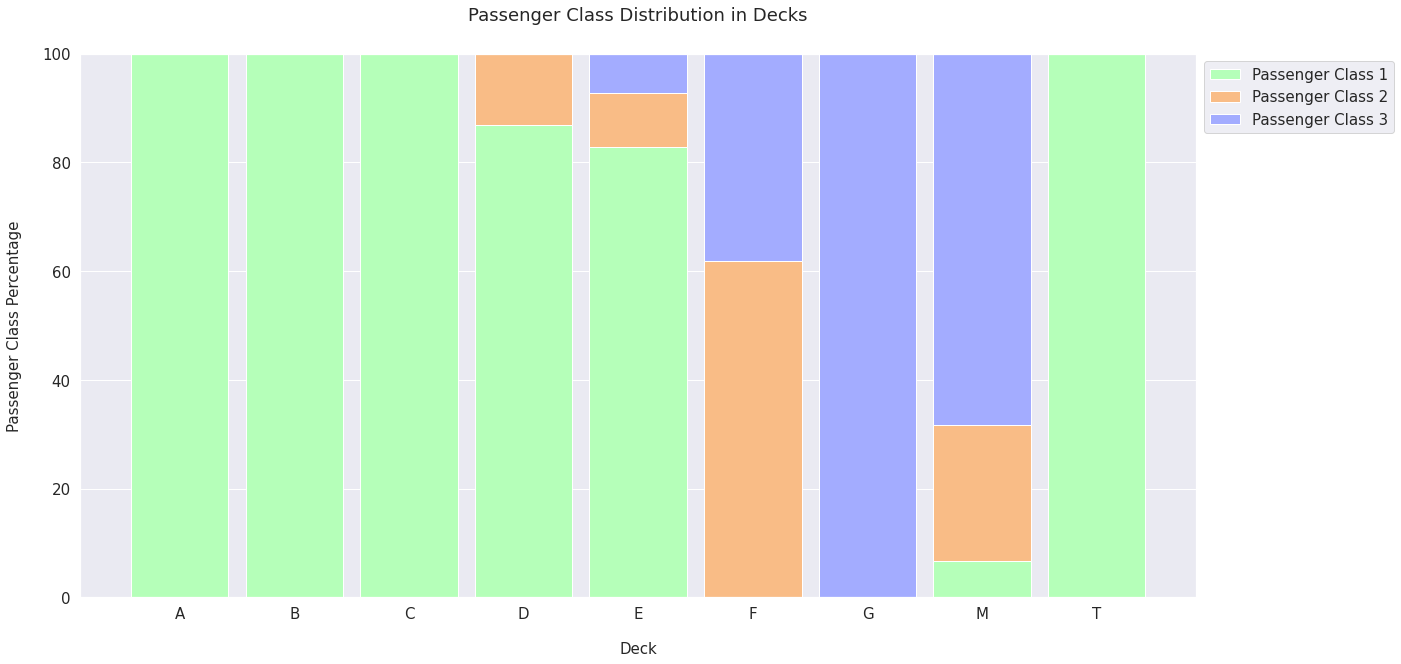

In [115]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
  deck_counts = {'A': {},'B': {},'C': {},'D': {},'E': {},'F': {},'G': {},'M': {},'T': {}}
  decks = df.columns.levels[0]
  
  for deck in decks:
    for pclass in range(1,4):
      try: 
        count = df[deck][pclass][0]
        deck_counts [deck][pclass] = count
      except KeyError:
        deck_counts[deck][pclass] = 0
  df_decks = pd.DataFrame(deck_counts)
  deck_percentages = {}

  for col in df_decks.columns:
    deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]

  return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)


Here we can see the breakdown of passenger class percentages by deck. From this we can now remove the lone cabin "T" from the dataset and move the only person that was in that cabin into the "A" deck as clearly 100% of passengers in the A deck were first class passengers.

In [116]:
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

Now we will analyse survival by deck to see if we can gather any patterns from that

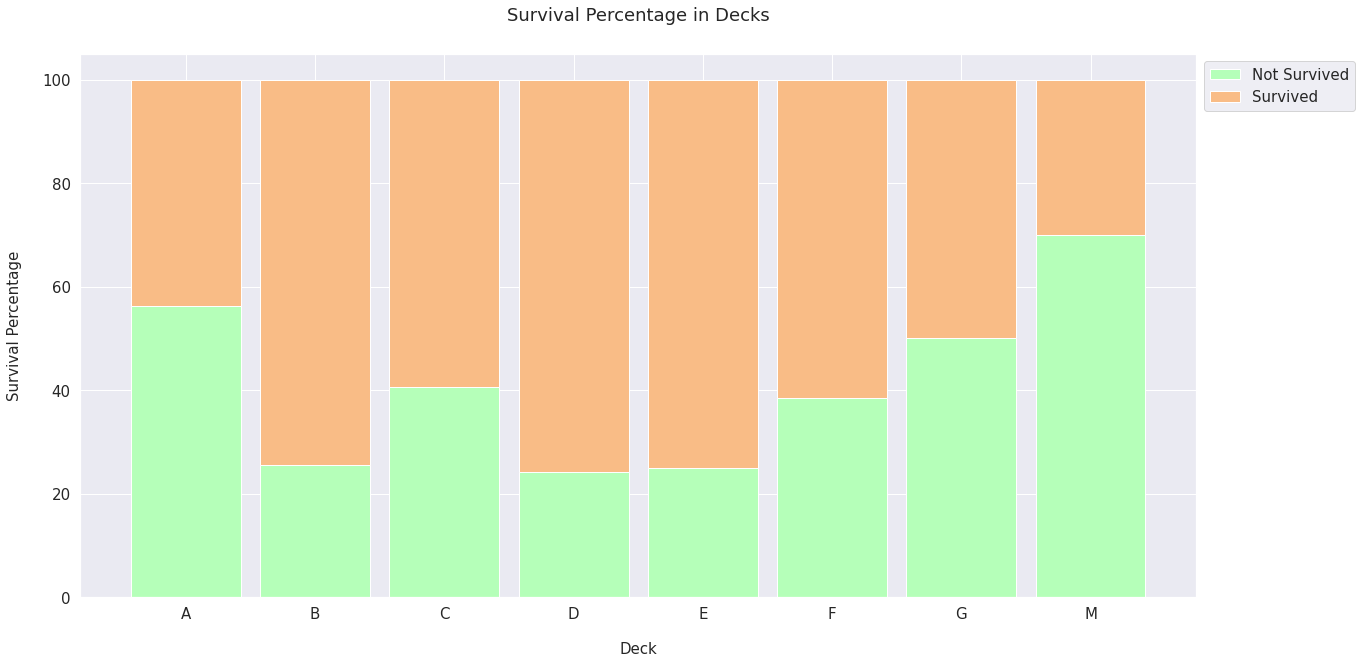

In [117]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Ticket', 'Cabin', 'Pclass', 'PassengerId']).rename(columns={'Name': 'Count'}).transpose()

def get_survived_dist(df):
  surv_counts = {'A': {},'B': {},'C': {},'D': {},'E': {},'F': {},'G': {},'M': {}}
  decks = df.columns.levels[0]
  
  for deck in decks:
    for survive in range(0,2):
        surv_counts[deck][survive] = df[deck][survive][0]

  df_surv = pd.DataFrame(surv_counts)
  surv_percentages = {}

  for col in df_surv.columns:
    surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]

  return surv_counts, surv_percentages

def display_surv_dist(percentages):
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

As we can see, different decks have different survival rates.

We now:
-  Group decks A, B and C as they all contain first class passengers only
- Group decks D and E as both have similar passenger class distribution and same survival rate.
- F and G for the same reason as above
- M deck is very different from the others and so remains independent

In [118]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [119]:
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




### Correlations
Now it's time to check some correlations in order to spot patterns between features

In [123]:
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [125]:
# training set correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.549500
8,Pclass,Age,0.417667
10,SibSp,Parch,0.414838
12,Survived,Pclass,0.338481
14,Survived,Fare,0.257307
16,SibSp,Age,0.249747
18,Parch,Fare,0.216225
20,Age,Parch,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [127]:
# test set correlations
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.577489
8,Age,Pclass,0.526789
10,Age,Fare,0.345347
12,SibSp,Parch,0.306895
14,Fare,Parch,0.230410
16,SibSp,Fare,0.172032


## Feature Engineering

### Binning Continous Features
> The problem of working with raw, continuous numeric features is that often the distribution of values in these features will be skewed. This signifies that some values will occur quite frequently while some will be quite rare.
[source](https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b)

Hence, binning is a discretisation of continuous data by placing ranges into 'bins'.

#### Fare


In [129]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

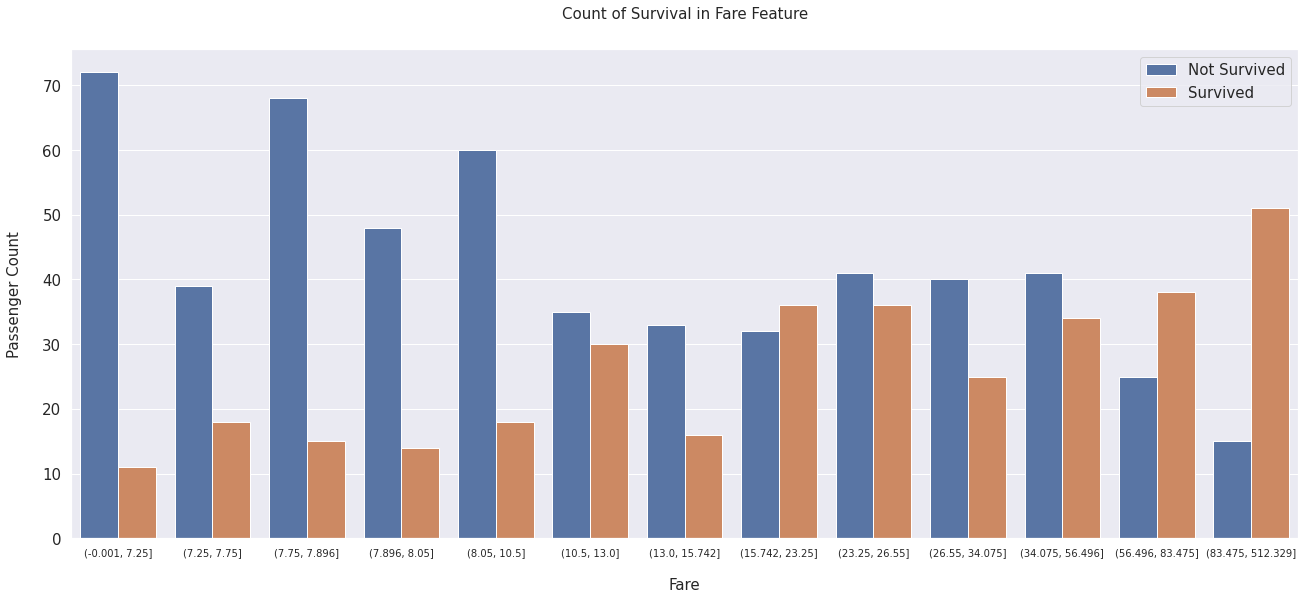

In [130]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

Here we can see that as fare increases survival rate increases

#### Age

In [132]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

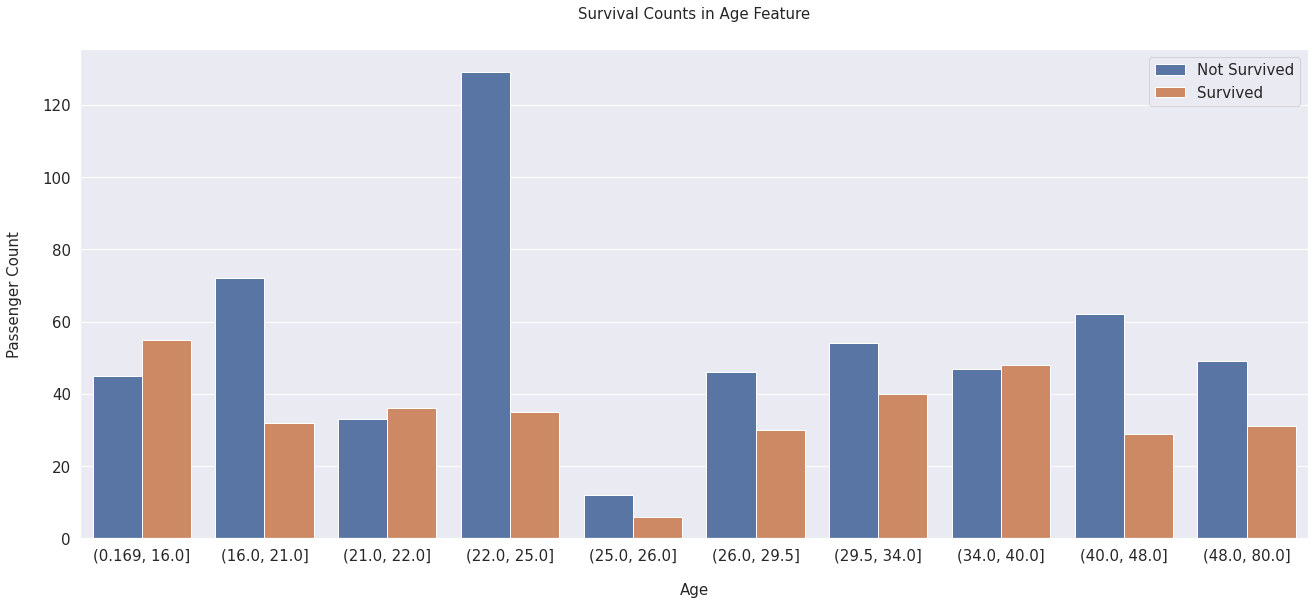

In [133]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

### Frequency Encoding
> Most of the Machine learning algorithms can not handle categorical variables unless we convert them to numerical values. Many algorithm’s performances vary based on how Categorical variables are encoded.
> 
> Categorical variables can be divided into two categories: Nominal (No particular order) and Ordinal (some ordered).


[source](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02)


> It is a way to utilize the frequency of the categories as labels. In the cases where the frequency is related somewhat with the target variable, it helps the model to understand and assign the weight in direct and inverse proportion, depending on the nature of the data. Three-step for this :
1. Select a categorical variable you would like to transform
2. Group by the categorical variable and obtain counts of each category
3. Join it back with the training dataset

[source](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02)



#### Family Size

For this dataset a potentially useful feature to have is family size. We realise this from a number of graphs where we find correlation between survival rates and various family size-related features.

For family size we simply sum `SibSp`, `Parch` and 1 (for the individual themself)

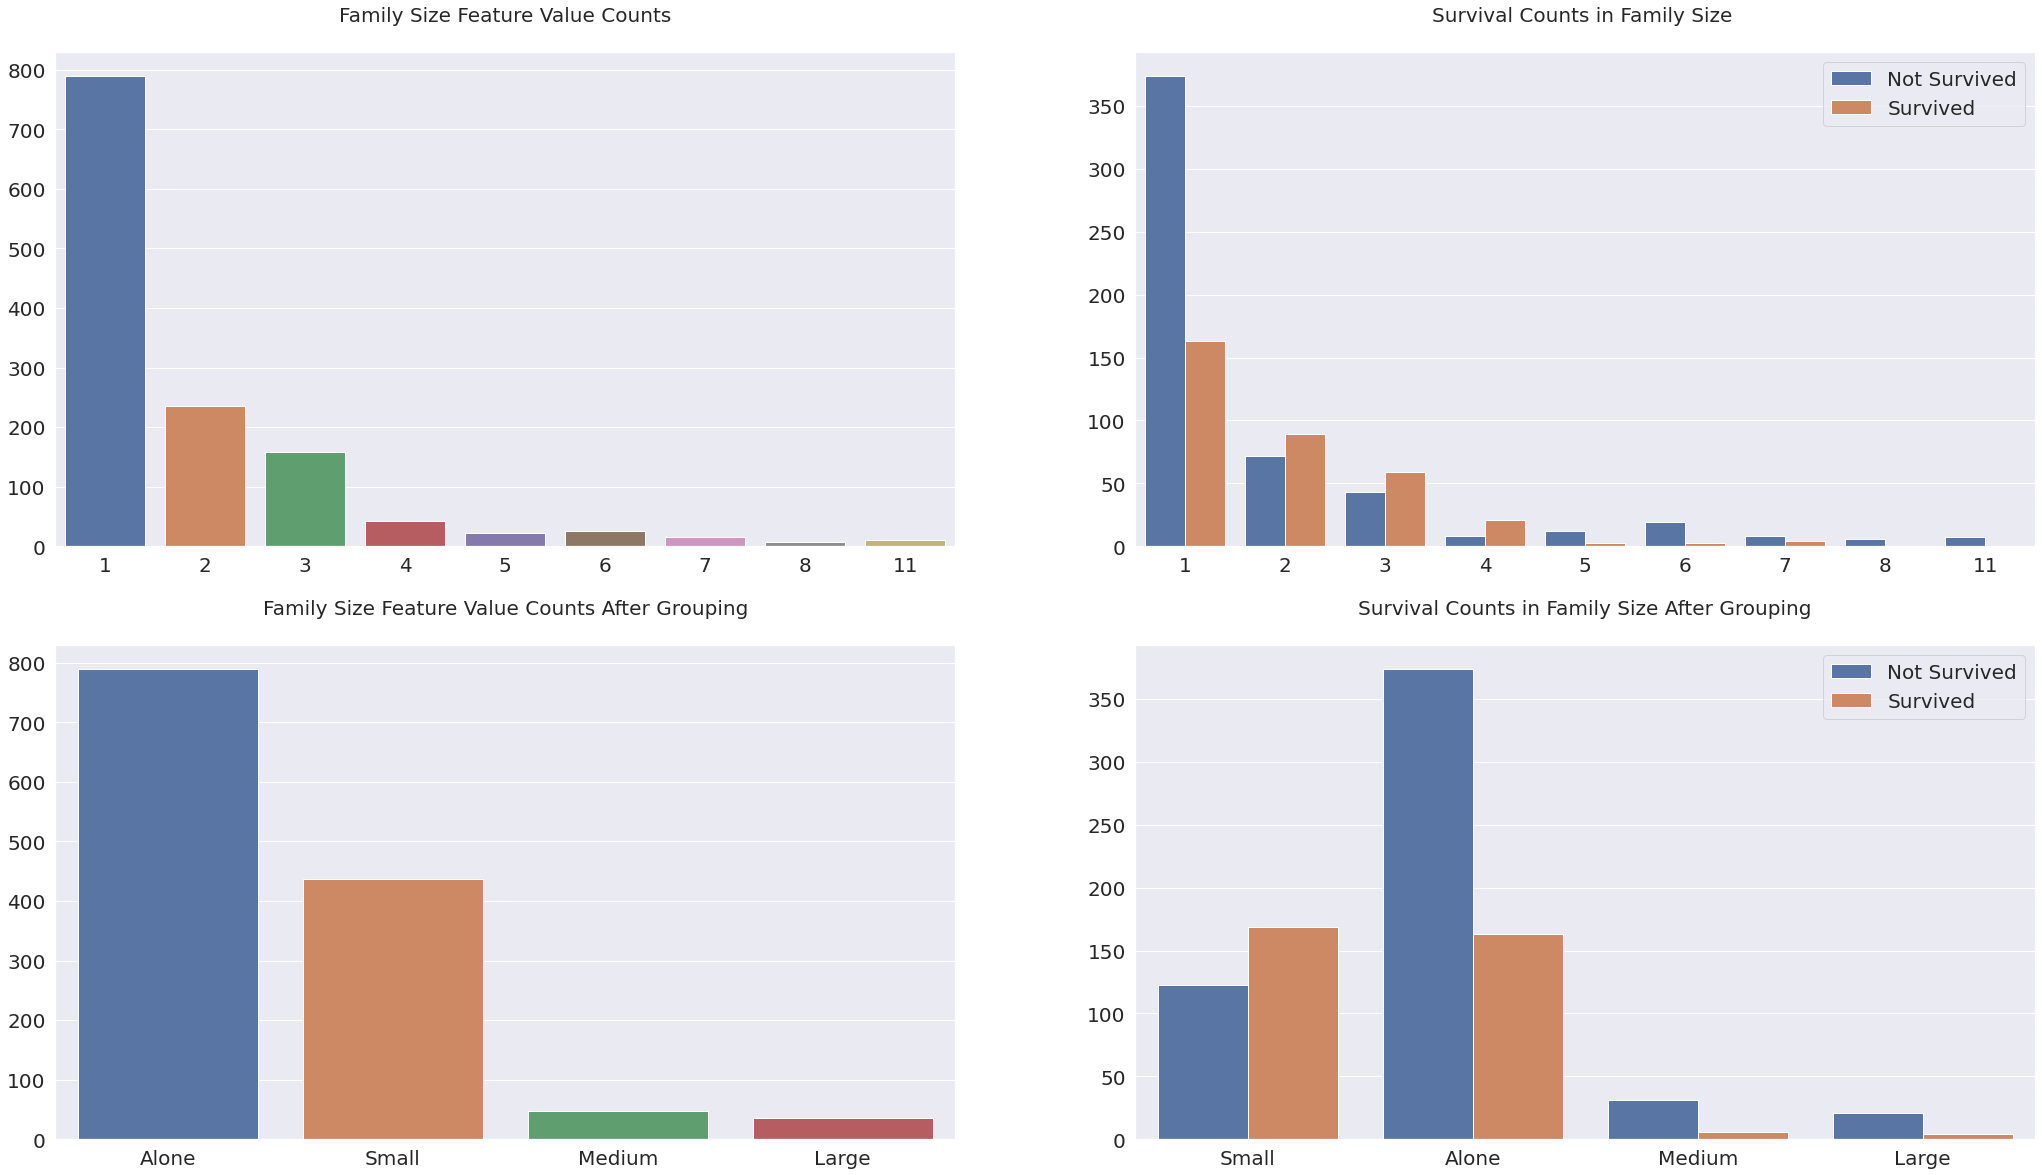

In [134]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

#### Tickets
There are a lot of different ticket values to analyse so instead we group them by their frequencies to make things easier.

This also accounts for groups that travelled together but weren't strictly family. So, maids, friends, nannies, etc.

In [136]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

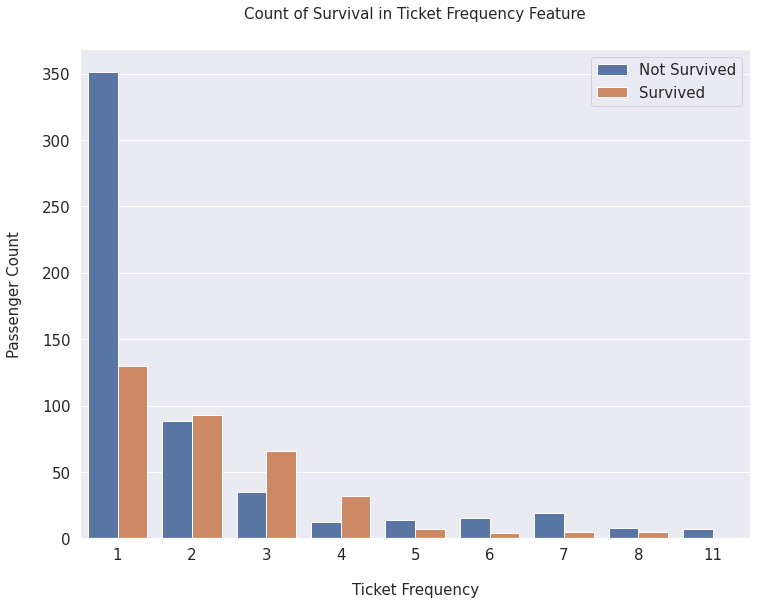

In [137]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

#### Title & Is Married?
Titles say quite a bit about a person, with **Mrs** having the highest survival rate among other female title. Hence, we need to split these up.
We are likewise able to group certain titles that posess similar characteristics

In [138]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

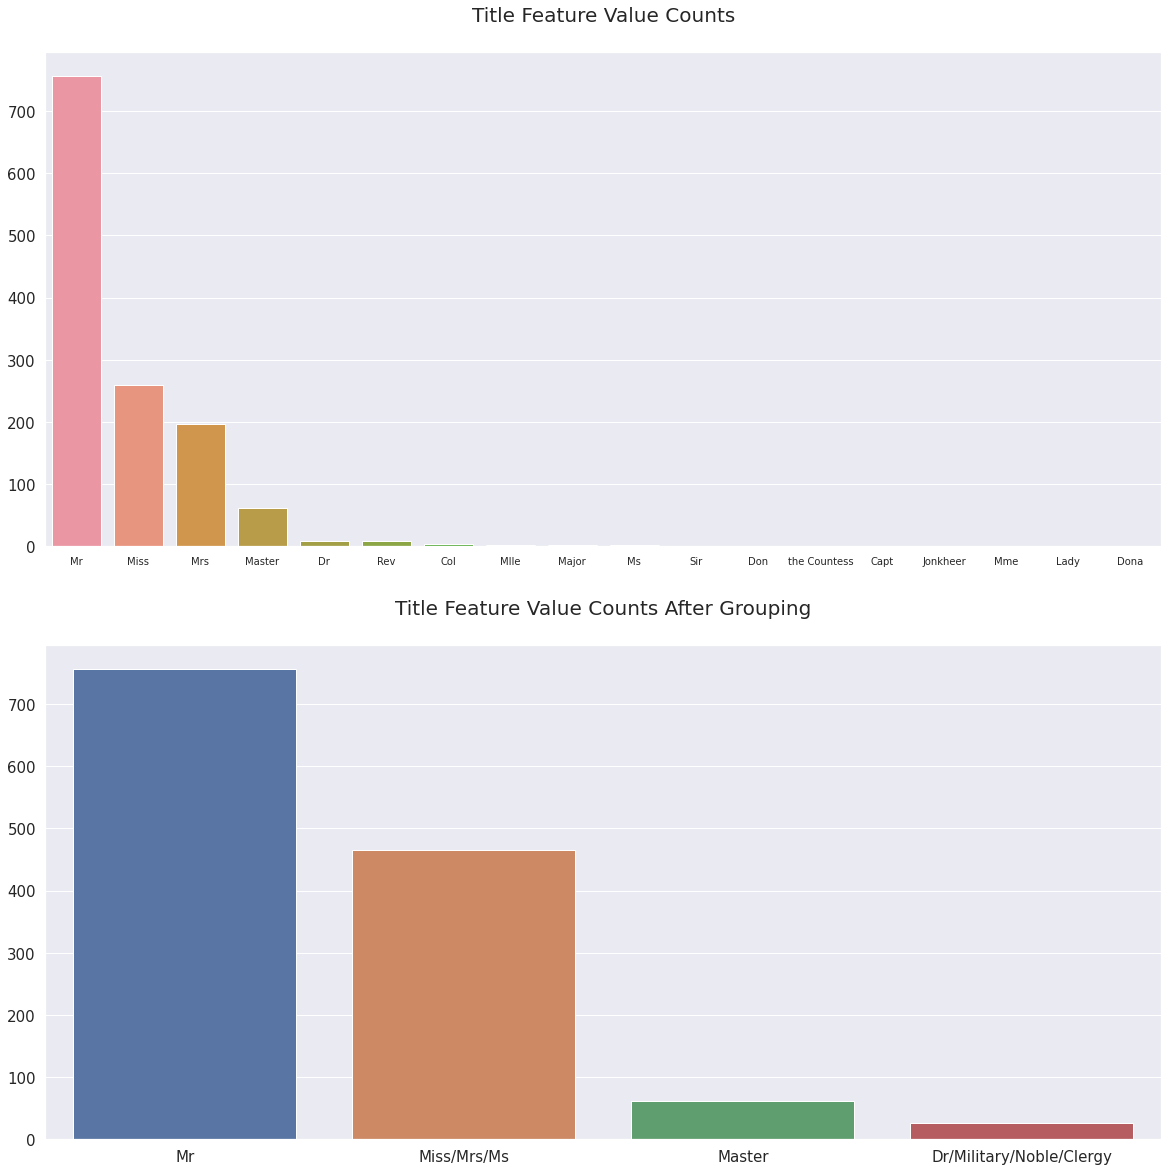

In [139]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

### Target Encoding

> Mean Encoding or Target Encoding is one viral encoding approach followed by Kagglers. There are many variations of this. Here I will cover the basic version and smoothing version. Mean encoding is similar to label encoding, except here labels are correlated directly with the target. For example, in mean target encoding for each category in the feature label is decided with the mean value of the target variable on a training data. This encoding method brings out the relation between similar categories, but the connections are bounded within the categories and target itself. The advantages of the mean target encoding are that it does not affect the volume of the data and helps in faster learning. Usually, Mean encoding is notorious for over-fitting; thus, a regularization with cross-validation or some other approach is a must on most occasions. Mean encoding approach is as below:
>1. Select a categorical variable you would like to transform
2. Group by the categorical variable and obtain aggregated sum over the “Target” variable. (total number of 1’s for each category in ‘Temperature’)
3. Group by the categorical variable and obtain aggregated count over “Target” variable
4. Divide the step 2 / step 3 results and join it back with the train.
[source](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02)

#### Family
We use this in order to group passengers into the same family.

In [140]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

We create `Family_Survival_Rate` feature as there is no `Survived` feature in test set. We then create a list of family names that are in both training and test sets

`Family_Survival_Rate_NA` is created for families that are unique to the test set and such we would have no way to calculate survival rates for those families otherwise.

`Ticket_Survival_Rate` and the like are created for the same reasons

In [142]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

df_family_survival_rate = df_train.groupby('Family')['Survived', 'Family','Family_Size'].median()
df_ticket_survival_rate = df_train.groupby('Ticket')['Survived', 'Ticket','Ticket_Frequency'].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [143]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [144]:
for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2

### Feature Transformation

#### Label Encoding Non-Numerical Features
We use LabelEncoder in order to give each feature a numerical value from 0 to n so that the model can learn from the features.

In [147]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

#### One-Hot Encoding the Categorical Features
The categorical features (`Pclass`, `Sex`, `Embarked`, `Title`) are converted to one-hot encoded features with `OneHotEncoder`. Age and Fare are njot encoded this way as they are ordinal unlike the above nominal categories. 


In [148]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

### Conclusion
Age and Fare features are binned. Binning helped dealing with outliers and it revealed some homogeneous groups in those features. Family_Size is created by adding Parch and SibSp features and 1. Ticket_Frequency is created by counting the occurence of Ticket values.

Name feature is very useful. First, Title and Is_Married features are created from the title prefix in the names. Second, Family_Survival_Rate and Family_Survival_Rate_NA features are created by target encoding the surname of the passengers. Ticket_Survival_Rate is created by target encoding the Ticket feature. Survival_Rate feature is created by averaging the Family_Survival_Rate and Ticket_Survival_Rate features.

Finally, the non-numeric type features are label encoded and categorical features are one-hot encoded. Created 5 new features (Family_Size, Title, Is_Married, Survival_Rate and Survival_Rate_NA) and dropped the useless features after encoding.

In [150]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4,Fare,Is_Married,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Survival_Rate,Survival_Rate_NA,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.0,0.0,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,11,1,1.0,0.0,0.0,1.0,0.0,1.000000,1.0,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3,0,0.0,0.0,1.0,1.0,0.0,0.383838,0.0,1,0.0,0.0,1.0,0.0
3,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,10,1,1.0,0.0,0.0,1.0,0.0,0.383838,0.0,2,0.0,0.0,1.0,0.0
4,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3,0,0.0,0.0,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0


## Model

In [151]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 26)
y_train shape: (891,)
X_test shape: (418, 26)


### Random Forest

Using a random forest model is a good start due to how the many different features we have in the data. Finding patterns between the features is something that random forest is good at. 

In [152]:
model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1) 

StratifiedKFold is used for stratifying the target variable. The folds are made by preserving the percentage of samples for each class in target variable (Survived).

In [153]:
# n.o folds
N = 5
# average prediction error
oob = 0
# fold probabilities dataframe
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
# find which features are the most important in determining predictions
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
#false/true positive rates
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    model.fit(X_train[trn_idx], y_train[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
      
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = model.feature_importances_
        
    oob += model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, model.oob_score_))   
    
print('Average OOB Score: {}'.format(oob))

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

Fold 1 OOB Score: 0.8553370786516854

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

Fold 2 OOB Score: 0.844319775596073

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

Fold 3 OOB Score: 0.8513323983169705

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

Fold 4 OOB Score: 0.8359046283309958

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

Fold 5 OOB Score: 0.8260869565217391

Average OOB Score: 0.8425961674834928


#### Feature Importance
Now we have trained we can see which features were the most important to the model

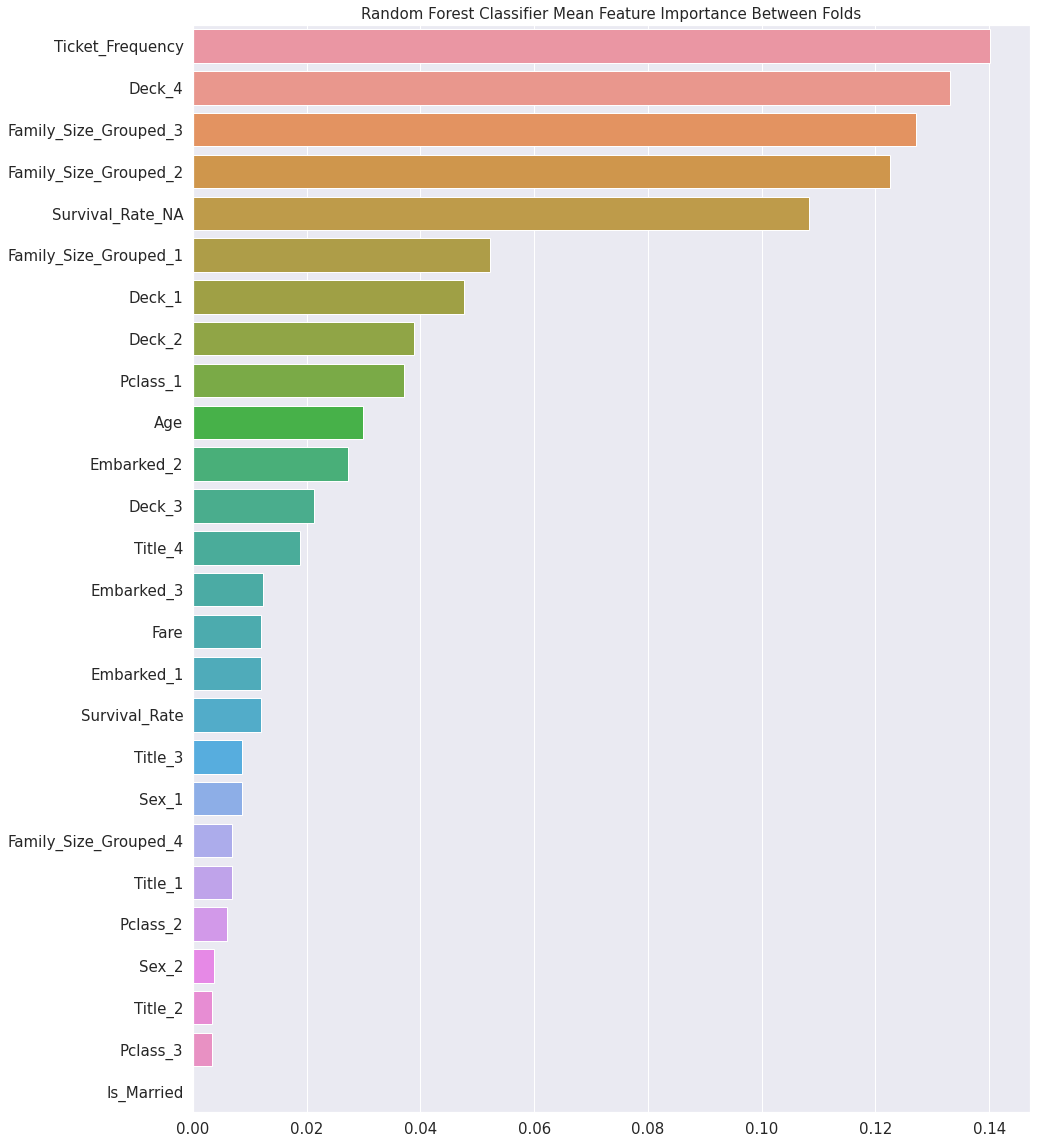

In [154]:
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(x='Mean_Importance', y=importances.index, data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)

plt.show()

#### ROC Curve
ROC Curve plots summarises all confusion matrices that each threshold produced. 

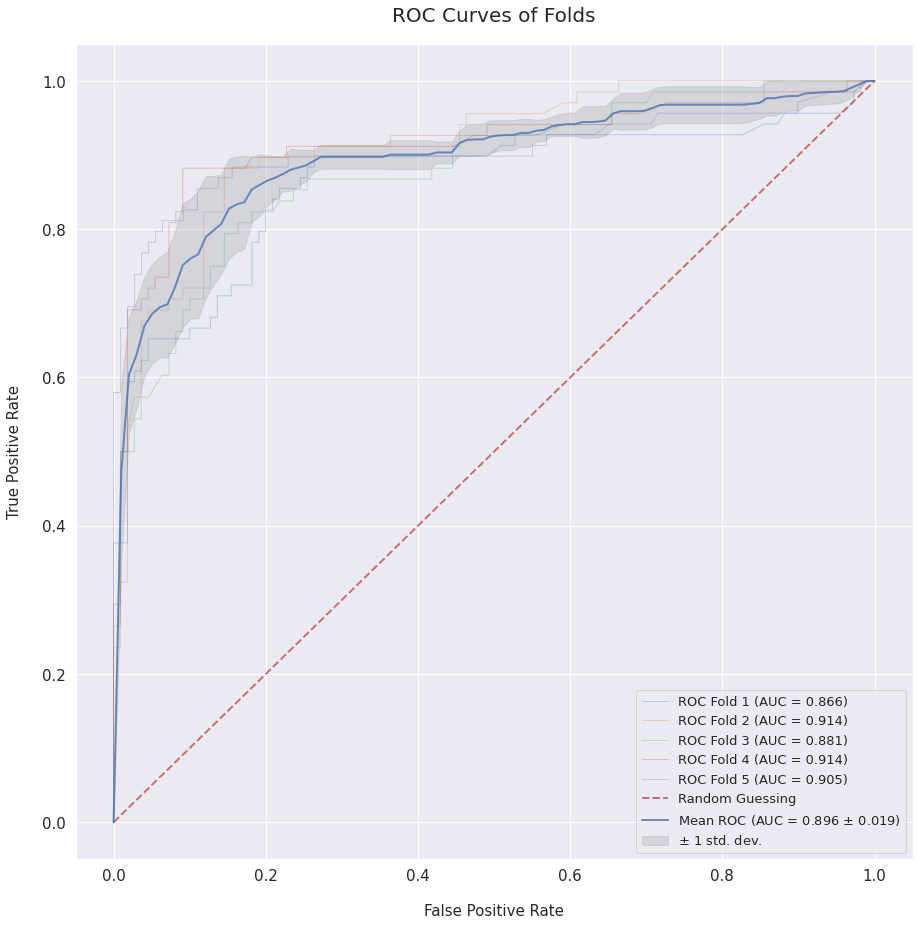

In [155]:
def plot_roc_curve(fprs, tprs):
    
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))
    
    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))
        
    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), lw=2, alpha=0.8)
    
    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')
    
    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})
    
    plt.show()

plot_roc_curve(fprs, tprs)

In [156]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(10)

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
896,897,0
897,898,1
898,899,0
899,900,1
900,901,0


In [157]:
! kaggle competitions submit -c titanic -f submissions.csv -m "v2, better data exploration, feature generation"

100% 2.77k/2.77k [00:00<00:00, 10.7kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster